In [34]:
from flymazerl.agents.nn import GQLearner, GRNNLearner
from flymazerl.gym.environment import ymaze_static, ymaze_baiting
from itertools import product
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import os
import seaborn as sns
from tqdm.notebook import tqdm
import json
import matplotlib.transforms as transforms
import matplotlib as mpl
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from flymazerl.agents.classical import *
from flymazerl.gym.environment import ymaze_baiting,ymaze_static
from flymazerl.utils import generate_params_from_fits,get_schedule_histories, get_schedule_values,get_agent_value_history
from flymazerl.utils import generate_random_schedule_with_blocks
from flymazerl.utils.generators import generate_random_schedule_with_blocks
from scipy import stats
from scipy.optimize import minimize
import gym
import pickle

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

# create a diverging color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#ffffff','#fe6100']
cmap_d = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs_d', hex_list)


def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

# calculate the paired cohens d for two distributions
def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

# calculate the cliff's delta for two distributions
def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''


def smoothen(x,width):
    if len(x.shape) == 1:
        # check if the first index is a number
        if isinstance(x[0],(int,float,np.float64,np.int64,np.float32,np.int32)):
            # add padding with 0.5 to avoid edge effects
            x = np.concatenate([np.ones(width-1)*0.5, x])
            # convolve with a boxcar
            x = np.convolve(x, np.ones(width)/width, mode='valid')
            return x
        else:
            xs = []
            for x_ in x:
                xs.append(smoothen(x_,width))
            return np.array(xs)
    elif len(x.shape) == 2:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    elif len(x.shape) == 3:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    else:
        raise ValueError("x must be 1, 2 or 3 dimensional")
        
mpl.rcParams.update(mpl.rcParamsDefault)

In [35]:
data_dir = "../../FlYMazeRL_Fits/nn/mohanta2022/"
folders = os.listdir(data_dir)
folders = [os.path.join(data_dir, f) for f in folders]

overwrite = False

if not os.path.exists("data/nn_data.pkl") or overwrite:
    full_data = pd.DataFrame()
    for folder in tqdm(folders):
        # check if folder is a directory and not .archived
        if not os.path.isdir(folder) or folder.endswith(".archived"):
            print("skipping", folder)
            continue
        # load params.json from each folder
        with open(os.path.join(folder, 'params.json')) as f:
            params = json.load(f)
        # load data from each folder
        try:
            data = pd.read_csv(os.path.join(folder, 'results.csv.gz'), compression='gzip')
        except FileNotFoundError:

            continue
        # att remaining params to data
        keys = [i for i in params.keys() if i not in ['save_path', 'action_set_data', 'reward_set_data','n_ensemble','print_every']]
        for key in keys:
            if key == 'hidden_state_sizes':
                data[key] = 'x'.join(map(str, params[key]))
            else:
                data[key] = params[key]
        # append to full_data
        full_data = pd.concat([full_data, data], ignore_index=True)
    full_data.to_pickle('data/nn_data.pkl')
else:
    full_data = pd.read_pickle('data/nn_data.pkl')

In [36]:
# Load Training Data
training_choice_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/training_choice_set.csv', delimiter=',')
training_reward_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/training_reward_set.csv', delimiter=',')
# Load Test Data
test_choice_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/test_choice_set.csv', delimiter=',')
test_reward_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/test_reward_set.csv', delimiter=',')

In [37]:
reduced_data = full_data.groupby(['ModelID', 'Model Path']).first().reset_index().drop(columns=['LogLikelihood(train)', 'AIC(train)', 'BIC(train)', \
            'MSE(test)','NMSE(test)', 'LogLikelihood(test)', 'AIC(test)', 'BIC(test)','P(action)','Training Loss', 'Validation Loss', \
            'Best Validation Loss', 'Epochs', 'Best Validation Epoch','Training Time','n_folds', 'history_size', 'max_epochs','early_stopping', \
            'learning_rate', 'weight_decay', 'train_test_split','tolerance','device','FoldID','FlyID','MSE(train)','NMSE(train)','minibatch_size', 'minibatch_seed'])
reduced_data['simple_model'] = reduced_data.apply(lambda x: x['agent'] + '_' + str(x['reservoir_size'] if x['agent'] == 'GRNN' else x['hidden_state_sizes']) + '_' + ('S' if x['symmetric'] else 'AS'), axis=1)

In [43]:
# drop asymRQN(200)
reduced_data = reduced_data[np.logical_and(reduced_data['simple_model'] != 'GRNN_200_AS',reduced_data['simple_model'] != 'GRNN_200_S')]

In [44]:
reduced_data.columns

Index(['ModelID', 'Model Path', 'EnsembleID', 'nParams', 'agent',
       'use_lr_scheduler', 'reservoir_size', 'num_reservoirs', 'encoder_size',
       'kind', 'hidden_state_sizes', 'activation', 'policy_type', 'symmetric',
       'allow_negative', 'omission_is_punishment', 'hardness', 'simple_model'],
      dtype='object')

In [57]:
overwrite = False
# loop over simple model ids
for simple_model in reduced_data['simple_model'].unique():
    if not os.path.exists(f"data/{simple_model}_fit_results.pkl") or overwrite:
        # get data for this simple model
        data = reduced_data[reduced_data['simple_model'] == simple_model].reset_index(drop=True)
        # prepare the model and environment
        env = ymaze_static(None, None)
        model_type = data['agent'][0]

        # create learner parameters
        learner_params = {
            "allow_negative_values": False,
            "symmetric_q_function": data['symmetric'][0],
            "omission_is_punishment": False,
            "policy_type": 'acceptreject',
            "device": 'cpu',
            "pre_trained": False,
            "model_path": None,
            "multi_agent": False,
            "n_agents": 1,
        }
        if data.agent[0] == "GQNN":
            learner_params["hidden_state_sizes"] = [int(x) for x in data['hidden_state_sizes'][0].split('x')]
            learner_params["activation"] = "relu"
            learner = GQLearner(env,learner_params)
        elif data.agent[0] == "GRNN":
            learner_params["encoder_size"] = None
            learner_params["num_layers"] = 1
            learner_params["reservoir_size"] = int(data['reservoir_size'][0])
            learner_params["kind"] = 'RNN'
            learner = GRNNLearner(env, learner_params)

        training_predictions = []
        test_predictions = []
        train_likelihoods = []
        test_likelihoods = []
        
        for index in tqdm(range(len(data))):
            entry = data.iloc[index]
            model_id = entry['ModelID']
            path = entry['Model Path']
            model_path = f"../../FlYMazeRL_Fits/nn/mohanta2022/{model_id}/{path}.pt"
            
            # load model
            learner.load_pre_trained_model(model_path)

            train_p_action = learner.get_action_probabilities_from_data(training_choice_set, training_reward_set)[:,:,1]
            p_action_shape = train_p_action.shape[1]
            train_likelihood =  np.exp(np.nanmean(training_choice_set[:,:p_action_shape] * np.log(train_p_action) + (1-training_choice_set[:,:p_action_shape]) * np.log(1-train_p_action), axis=1))

            test_p_action = learner.get_action_probabilities_from_data(test_choice_set, test_reward_set)[:,:,1]
            p_action_shape = test_p_action.shape[1]
            test_likelihood =  np.exp(np.nanmean(test_choice_set[:,:p_action_shape] * np.log(test_p_action) + (1-test_choice_set[:,:p_action_shape]) * np.log(1-test_p_action), axis=1))

            train_likelihoods.append(train_likelihood)
            test_likelihoods.append(test_likelihood)
            training_predictions.append(train_p_action)
            test_predictions.append(test_p_action)
            
        # convert to numpy arrays
        train_likelihoods = np.array(train_likelihoods)
        test_likelihoods = np.array(test_likelihoods)
        training_predictions = np.array(training_predictions)
        test_predictions = np.array(test_predictions)

        # save
        fit_results = {
            'training_nll': train_likelihoods,
            'test_nll': test_likelihoods,
            'training_predictions': training_predictions,
            'test_predictions': test_predictions,
            'params': learner_params,
            'model': learner,
        }

        with open(f"data/{simple_model}_fit_results.pkl", 'wb') as f:
            pickle.dump(fit_results, f)

In [58]:
def get_pickled_data(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def get_variable_from_dataset(dataset, variable):
    vars = [v[variable] for v in dataset]
    return vars

models = ["data/"+model for model in os.listdir("data/") if model.endswith("fit_results.pkl") and "NN" in model]
# sort models by reservoir size
models = sorted(models, key=lambda x: int(x.split("_")[1]) if "GRNN" in x else int(x.split("_")[1].split("x")[0]) + len(x.split("_")[1]))
# sort models by symmetry
models = sorted(models, key=lambda x: x.split("_")[2])
# sort models as GQNN and GRNN
models = sorted(models, key=lambda x: x.split("_")[0])
# get data
dataset = [get_pickled_data(model) for model in tqdm(models)]

  0%|          | 0/28 [00:00<?, ?it/s]

In [59]:
# get model
test_nlls = get_variable_from_dataset(dataset, "test_nll")
training_nlls = get_variable_from_dataset(dataset, "training_nll")
test_preds = get_variable_from_dataset(dataset, "test_predictions")
training_preds = get_variable_from_dataset(dataset, "training_predictions")

def get_means_and_se(data):
    means = np.array([np.mean(x) for x in data])
    se = np.array([np.std(x)/np.sqrt(x.shape[1]) for x in data])
    return means, se

def get_probs_and_ci(data,widths):
    probs = []
    cis = []
    for x in data:
        probs.append(np.mean(smoothen(x, widths), axis=0))
        cis.append((np.percentile(smoothen(x, widths), 2.5, axis=0), np.percentile(smoothen(x, widths), 97.5, axis=0)))
    probs = np.array([x[:,:159] for x in probs])
    cis = np.array([(x[0][:,:159], x[1][:,:159]) for x in cis])
    return probs, cis

training_means, training_se = get_means_and_se(training_nlls)
test_means, test_se = get_means_and_se(test_nlls)
training_probs, training_cis = get_probs_and_ci(training_preds, 10)
test_probs, test_cis = get_probs_and_ci(test_preds, 10)

In [60]:
def name_cleaner(model):
    name = "sym" if "_S_" in model else "asym"
    name += "RqN" if "GRNN" in model else "FFqN"
    name += "(" + model.split("_")[1] + ")"
    return name
names = [name_cleaner(model) for model in models]

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

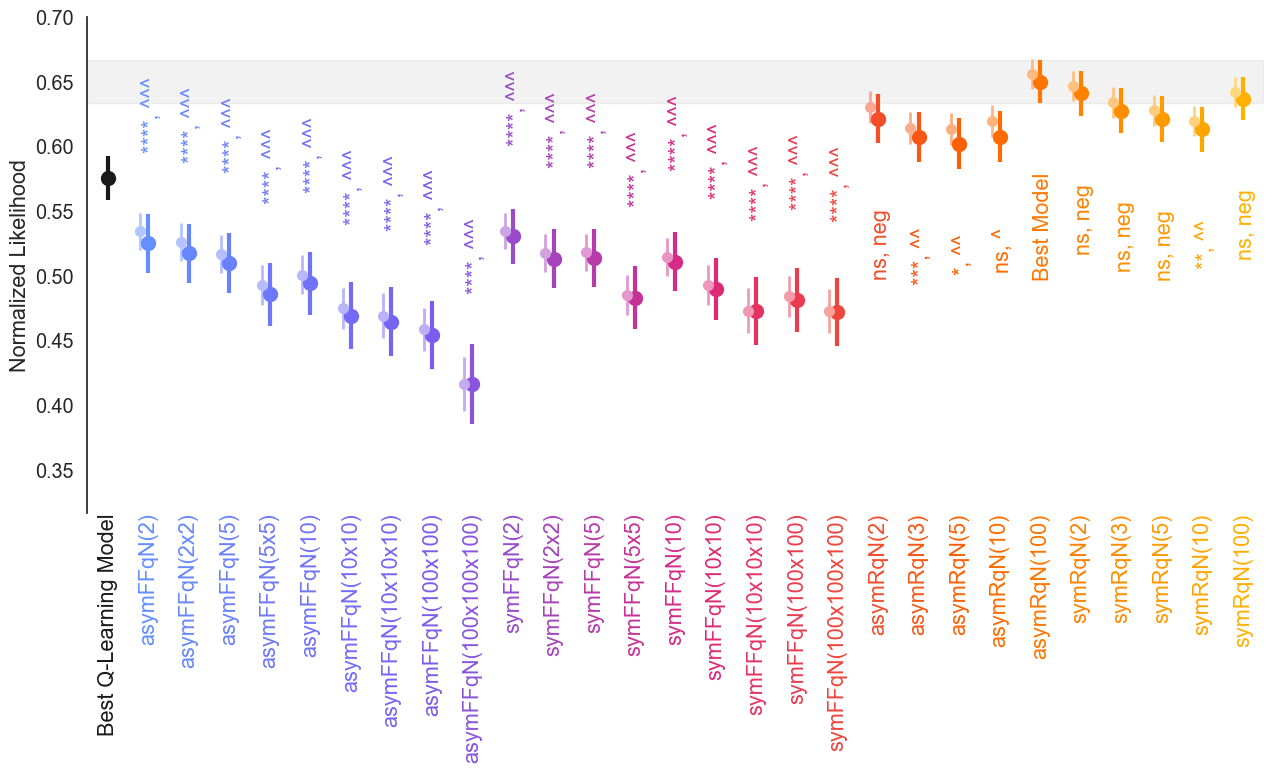

In [74]:
# find statistically significant differences and effect sizes
best_model = np.argmax(test_means)

pvals = []
rs = []
for i in range(len(models)):
    pvals_temp = []
    for j in range(test_nlls[i].shape[0]):
        try:
            pvals_temp.append(stats.ttest_rel(test_nlls[i][j], test_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.nanquantile(pvals_temp, 0.95)
    pvals.append(pval)
    rs_temp = []
    for j in range(test_nlls[i].shape[0]):
        
        rs_temp.append(pairedCohensD(test_nlls[i][j], test_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    rs.append(r)

t_pvals = []
t_rs = []
for i in range(len(models)):
    pvals_temp = []
    for j in range(training_nlls[i].shape[0]):
        try:
            pvals_temp.append(stats.ttest_ind(training_nlls[i][j], training_nlls[best_model][j])[1])
        except:
            pvals_temp.append(np.nan)
    pval = np.quantile(pvals_temp, 0.95)
    t_pvals.append(pval)
    rs_temp = []
    for j in range(test_nlls[i].shape[0]):
        
        rs_temp.append(pairedCohensD(training_nlls[i][j], training_nlls[best_model][j]))
    r = np.quantile(np.abs(rs_temp), 0.05)
    t_rs.append(r)



sns.set(font_scale=1.3,style="white")
fig, ax = plt.subplots(figsize=(13,8))
ax.errorbar(-1, 0.575671, yerr=0.016984, color='k', elinewidth=3, markersize=10, fmt= 'o')
ax.text(-1, min(test_means)-0.1, 'Best Q-Learning Model', ha='center', va='top', rotation=90, color='k')
# # draw reference region
# ax.fill_between([-1.5, len(models)-0.5], 0.586156 - 0.044313, 0.586156 + 0.044313, color='grey', alpha=0.2)
for i in range(len(models)):    
    color=cmap(i/(len(models)-1))
    
    ax.errorbar(i, test_means[i], yerr=test_se[i], color=change_lightness(color, 1), elinewidth=3, markersize=10, fmt= 'o')
    ax.errorbar(i-0.2, training_means[i], yerr=training_se[i], color=change_lightness(color, 0.5), elinewidth=2, markersize=7, fmt= 'o')
    ax.text(i, min(test_means)-0.1, names[i], ha='center', va='top', rotation=90, color=change_lightness(color, 1))
    # add significance
    if i < 18:
        if i != best_model:
            ax.text(i+0.08, np.max(test_means[i])+0.07, f"{pvalue_to_stars(pvals[i])}, {d_to_effect(rs[i])}", ha='center', va='bottom', rotation=90, color=change_lightness(color, 1))
        else:
            ax.text(i+0.08, np.max(test_means[i])+0.07, f"Best Model", ha='center', va='bottom', rotation=90, color=change_lightness(color, 1))
    else:
        if i != best_model:
            ax.text(i+0.08, np.min(test_means[i])-0.07, f"{pvalue_to_stars(pvals[i])}, {d_to_effect(rs[i])}", ha='center', va='top', rotation=90, color=change_lightness(color, 1))
        else:
            ax.text(i+0.08, np.min(test_means[i])-0.07, f"Best Model", ha='center', va='top', rotation=90, color=change_lightness(color, 1))
# draw reference region
ax.fill_between([-1.5, len(models)-0.5], test_means[best_model]-test_se[best_model], test_means[best_model]+test_se[best_model], color='gray', alpha=0.1)
ax.set_xticks([])
ax.set_ylabel("Normalized Likelihood")
ax.set_ylim([min(test_means)-0.1, max(test_means)+0.05])
ax.set_xlim([-1.5, len(models)-0.5])
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig("figures/NN_summary.pdf", bbox_inches='tight')
plt.show()

In [75]:
statistics = pd.DataFrame({"Model": names, "Test NL": test_means, "Test SE": test_se, "Test p-value": pvals, "Test d": rs, "Training NL": training_means, "Training SE": training_se, "Training p-value": t_pvals, "Training d": t_rs})
statistics.to_csv("tables/NN_statistics.csv", index=False)

In [63]:
# find best model in each category
best_models = []
# category 1: asymmetrical GQNN
best_models.append(models[np.argmax(test_means[:9])])
# category 2: symmetrical GQNN
best_models.append(models[np.argmax(test_means[9:18])+9])
# category 3: asymmetrical FFQNN
best_models.append(models[np.argmax(test_means[18:24])+18])
# category 4: ssymmetrical FFQNN
best_models.append(models[np.argmax(test_means[24:])+24])

# filter in best models
filtered_models = [model for model in models if model in best_models]
filtered_names = [name for name in names if name in [name_cleaner(model) for model in best_models]]
filtered_training_nlls = [training_nlls[i] for i in range(len(models)) if models[i] in best_models]
filtered_test_nlls = [test_nlls[i] for i in range(len(models)) if models[i] in best_models]
filtered_training_preds = [training_preds[i] for i in range(len(models)) if models[i] in best_models]
filtered_test_preds = [test_preds[i] for i in range(len(models)) if models[i] in best_models]

# get means and standard errors
filtered_training_means, filtered_training_se = get_means_and_se(filtered_training_nlls)
filtered_test_means, filtered_test_se = get_means_and_se(filtered_test_nlls)
filtered_training_probs, filtered_training_cis = get_probs_and_ci(filtered_training_preds, 10)
filtered_test_probs, filtered_test_cis = get_probs_and_ci(filtered_test_preds, 10)

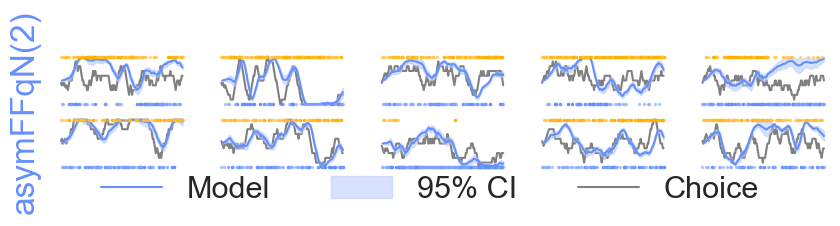

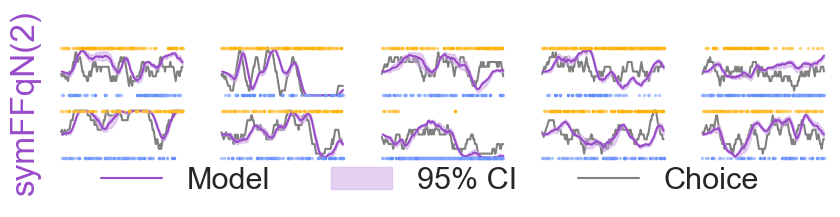

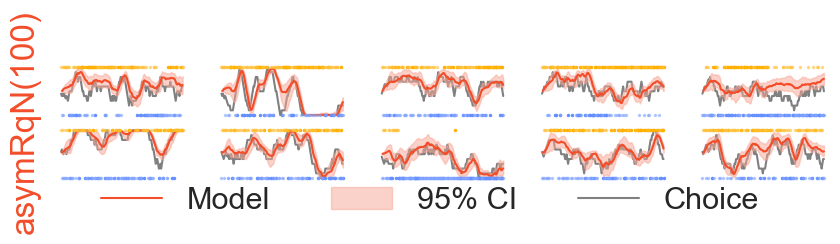

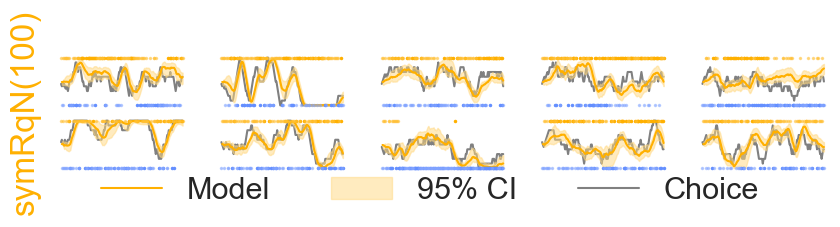

In [64]:
import warnings
warnings.filterwarnings('ignore')
# choose 10 random examples to plot
np.random.seed(13234)
random_examples = np.random.choice(np.arange(test_choice_set.shape[0]), 10, replace=False)

for n,(name,test_prob, test_ci) in enumerate(zip(filtered_names, filtered_test_probs, filtered_test_cis)):
    sns.set(font_scale=2,style="white")
    fig,ax = plt.subplots(2,5,figsize=(10,1.5),sharex=True,sharey=True,gridspec_kw={'wspace':0.2,'hspace':0.2})

    for i,data in enumerate(random_examples):
        width = 10
        
        true_choice = test_choice_set[data]
        true_choice = true_choice[~np.isnan(true_choice)]
        max_size = true_choice.shape[0]-1

        choice_prob = test_prob[data,:max_size]
        choice_prob_ci = test_ci[:,data,:max_size]

        if i == 0:
            ax.flat[i].plot(np.arange(1,max_size+1),choice_prob,label='Model',color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,max_size+1),choice_prob_ci[0,:],choice_prob_ci[1,:],label='95% CI',color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width),label='Choice', color='grey',zorder=-1)
        else:
            ax.flat[i].plot(np.arange(1,max_size+1),choice_prob,color=change_lightness(cmap(n/(len(filtered_models)-1)), 1),zorder=1)
            ax.flat[i].fill_between(np.arange(1,max_size+1),choice_prob_ci[0,:],choice_prob_ci[1,:] ,color=change_lightness(cmap(n/(len(filtered_models)-1)), 0.5),zorder=0,alpha=0.5)
            ax.flat[i].plot(smoothen(test_choice_set[data],width), color='grey',zorder=-1)

        
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 1))),'.',color=cmap(0.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))[0],
                            np.zeros(np.sum(np.logical_and(test_choice_set[i] == 0,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(0.),0.8),alpha=0.5,markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 1))),'.',color=cmap(1.),markersize=3)
        ax.flat[i].plot(np.where(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))[0],
                            np.ones(np.sum(np.logical_and(test_choice_set[i] == 1,test_reward_set[i] == 0))),'.',color=change_lightness(cmap(1.),0.8),alpha=0.5,markersize=3)
        
        for spine in ax.flat[i].spines.values():
            spine.set_visible(False)
        ax.flat[i].set_yticks([])
        ax.flat[i].set_xticks([])
    
    # give common x and y labels
    # fig.text(0.5, -0.02, 'Trial', ha='center')
    fig.text(0.08, 0.5, name , va='center', rotation='vertical', color=change_lightness(cmap(n/(len(filtered_models)-1)), 1))
    # add legend
    fig.legend(loc='lower center',ncol=4,frameon=False, bbox_to_anchor=(0.5, -0.3))
    # add title
    plt.tight_layout()
    plt.savefig('figures/{}_model_fit.pdf'.format(name.replace('(','').replace(')','').replace(' ','_')),bbox_inches='tight')
    plt.show()


## FFQN Analysis

In [65]:
def accept_reject_policy(qs):
    return torch.exp(torch.log(qs[:,1])+ torch.log(3-qs[:, 0])- torch.log(3*qs[:, 1] + 3*qs[:, 0] - 2*qs[:, 0]*qs[:, 1]))

def get_model_fom_entry(dataset,index,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/",env=None):
    """
    A function to get model from dataset
    """
    entry = dataset.iloc[index]
    model_id = entry['ModelID']
    model_type = entry['agent']
    path = entry['Model Path']
    model_path = model_directory + f"{model_id}/{path}.pt"
    
    if env is None:
        env = ymaze_static(None,None)

    # create learner parameters
    learner_params = {
        "allow_negative_values": False,
        "symmetric_q_function": entry['symmetric'],
        "omission_is_punishment": False,
        "policy_type": 'acceptreject',
        "device": 'cpu',
        "pre_trained": False,
        "model_path": None,
        "multi_agent": False,
        "n_agents": 1,
    }
    if model_type == "GQNN":
        learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
        learner_params["activation"] = "relu"
        learner = GQLearner(env,learner_params)
    elif model_type == "GRNN":
        learner_params["encoder_size"] = None
        learner_params["num_layers"] = 1
        learner_params["reservoir_size"] = int(data['reservoir_size'][0])
        learner_params["kind"] = 'RNN'
        learner = GRNNLearner(env, learner_params)

    # load model
    learner.load_pre_trained_model(model_path)

    return learner

def generate_GQNN_valuefield(dataset,index,resolution,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/"):
    """
    A function to generate a vector field for a GQNN given the dataset+index and limits and resolution of the value field.
    """
    
    learner = get_model_fom_entry(dataset,index,model_directory)

    omission = -1 if learner.omission_is_punishment else 0

    q_grid = np.array(list(product(np.linspace(0,1,resolution),np.linspace(0,1,resolution))))
    Xs, Ys, Us, Vs, zs, ARs = [],[],[],[],[],[]

    for count,action_reward_pair in zip(range(4),[[-1,1],[-1,omission],[1,1],[1,omission]]):

        with torch.no_grad():
            q = learner.agent.forward(torch.tensor(np.repeat([action_reward_pair],q_grid.shape[0],axis=0),dtype=torch.float),torch.tensor(q_grid,dtype=torch.float)).cpu()-torch.tensor(q_grid,dtype=torch.float)
        output = torch.tensor(q_grid)

        z = accept_reject_policy(output).cpu().detach().numpy().reshape(resolution,resolution)
        u,v = q[:,0].cpu().detach().numpy(),q[:,1].cpu().detach().numpy()

        X,Y = np.meshgrid(np.linspace(0,1,resolution),np.linspace(0,1,resolution))
        U,V = u.reshape(resolution,resolution).T,v.reshape(resolution,resolution).T

        Xs.append(X)
        Ys.append(Y)
        Us.append(U)
        Vs.append(V)
        zs.append(z)
        ARs.append(action_reward_pair)

    return Xs,Ys,Us,Vs,zs,ARs

def generate_behavior(dataset,index,schedule,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/",return_full_history=False):
    """
    A function to generate behavior for a given model given the dataset+index and schedule.
    """
    env = ymaze_static(len(schedule),schedule=schedule)

    learner = get_model_fom_entry(dataset,index,model_directory,env)

    # simulate the model
    learner.run_episode()

    if return_full_history:
        return learner.action_history,learner.reward_history,learner.get_q_history()
    else:
        return learner.action_history

def generate_learning_scores(dataset,index,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/"):
    """
    A function to generate learning and asymmetry scores for a given model given the dataset+index.
    """
    schedule = generate_random_schedule_with_blocks(100,[1],[0])
    action_histories_1 = generate_behavior(dataset,index,schedule,model_directory)
    schedule = generate_random_schedule_with_blocks(100,[0],[1])
    action_histories_2 = generate_behavior(dataset,index,schedule,model_directory)
    learning_score = (np.mean(action_histories_2) - np.mean(action_histories_1))
    asymmetry_score = np.abs(np.mean(action_histories_1) + np.mean(action_histories_2) - 1)
    return index,learning_score,asymmetry_score

def generate_GQNN_attractorspace(dataset,index,n_attractors,max_trials,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/"):
    """
    A function to generate the attractor space for a given model given the dataset+index.
    """
    learner = get_model_fom_entry(dataset,index,model_directory)

    omission = -1 if learner.omission_is_punishment else 0

    attractors = {
        0: [],
        1: [],
        2: [],
        3: [],
    }

    for count,action_reward_pair in enumerate([[-1,1],[-1,omission],[1,1],[1,omission]]):
        
        # generate random starting point
        x = np.random.uniform(0,1,size=n_attractors)
        y = np.random.uniform(0,1,size=n_attractors)
        start_point = np.array([x,y]).T
        q_value = torch.tensor(start_point,dtype=torch.float).to(learner.device)
        q_values = q_value.unsqueeze(1)
        ar = torch.tensor(np.repeat([action_reward_pair],n_attractors,axis=0),dtype=torch.float).to(learner.device)
        # run forward for max_trials
        with torch.no_grad():
            for j in range(max_trials):
                q_value = learner.agent.forward(ar,q_value)
                q_values = torch.cat((q_values,q_value.unsqueeze(1)),dim=1)
        #  get final q_value
        q_value = q_value.cpu().detach().numpy()
        # join with start point
        q_value = np.concatenate((q_value,start_point),axis=1)
        # get attractor
        attractors[count] = q_value.squeeze()
    
    return attractors

condition_map = {0:'C- R+',1:'C- R-',2:'C+ R+',3:'C+ R-'}

def plot_GQNN_valuefield(Xs,Ys,Us,Vs,zs,ARs,arrow=True,flow=True,show=True,arrow_color='k',flow_color='w',flow_density=1,figsize=(10,10),font_scale=1.5,flow_width=0.5):
    assert len(Xs) == len(Ys) == len(Us) == len(Vs) == len(zs) == len(ARs) == 4

    sns.set(font_scale=font_scale,style='white')

    fig, ax = plt.subplots(2,2,figsize=figsize, sharex=True, sharey=True)
    for count,action_reward_pair in enumerate(ARs):
        ax[count//2,count%2].imshow(zs[count],cmap=cmap_d,vmin=0,vmax=1,interpolation='bicubic',extent=[0,1,0,1],origin='lower')

        if arrow:
            ax[count//2,count%2].quiver(Xs[count],Ys[count],Us[count],Vs[count],color=arrow_color,width=0.0025)
        
        if flow:
            ax[count//2,count%2].streamplot(Xs[count],Ys[count],Us[count],Vs[count],density=flow_density,color=flow_color,linewidth=flow_width)

        # set title
        ax[count//2,count%2].set_title(condition_map[count])

        # set axis properties
        ax[count//2,count%2].set_ylim(0,1)
        ax[count//2,count%2].set_xlim(0,1)
        ax[count//2,count%2].set_xticks([0,0.5,1])
        ax[count//2,count%2].set_yticks([0,0.5,1])
        ax[count//2,count%2].set_xticklabels([0,r"$q^1$",1], ha='center', va='center')
        ax[count//2,count%2].set_yticklabels([0,r"$q^2$",1], rotation=90, ha='center', va='center')
        ax[count//2,count%2].set_aspect('equal')

    plt.tight_layout()
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ax.flatten()[0].imshow(zs[count],cmap=cmap_d,vmin=0,vmax=1,interpolation='bicubic',extent=[0,1,0,1],origin='lower'), cax=cbar_ax, label="Probability of choosing odor 2", orientation='vertical')
    cbar_ax.set_xlabel("Probability of choosing odor 2")

    if not show:
        return fig, ax
    else:
        plt.show()

In [66]:
for i in filtered_models:
    print(i)

data/GQNN_2_AS_fit_results.pkl
data/GQNN_2_S_fit_results.pkl
data/GRNN_100_AS_fit_results.pkl
data/GRNN_100_S_fit_results.pkl


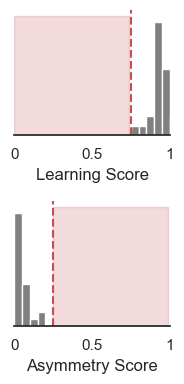

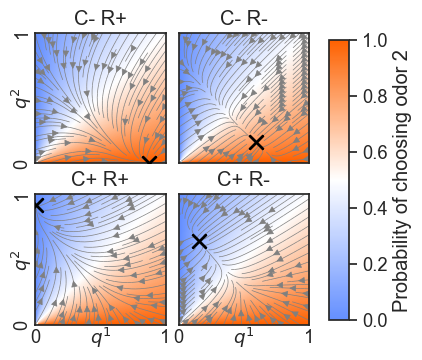

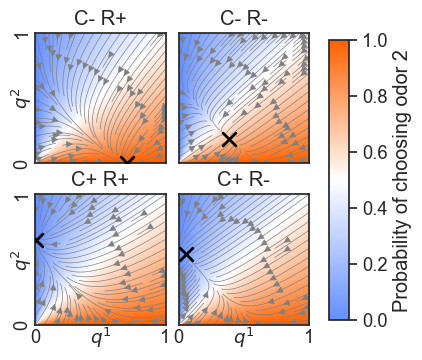

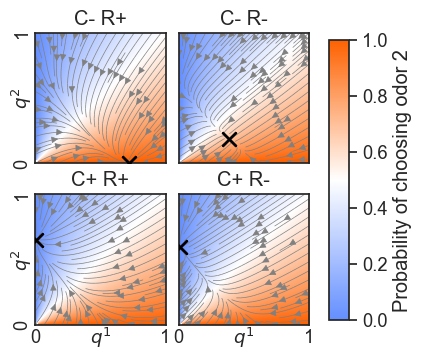

C- R+: 0.0
C- R-: 0.0
C+ R+: 0.0
C+ R-: 0.0


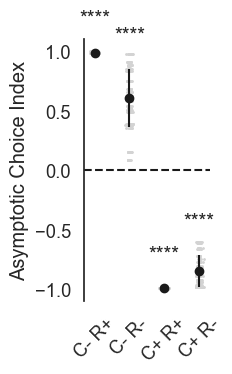

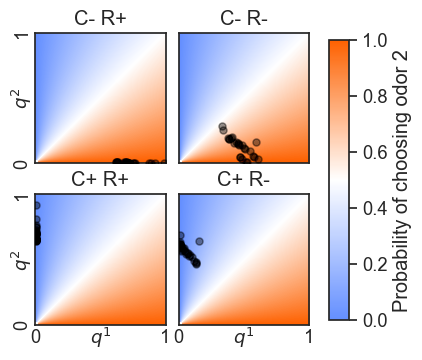

In [69]:
# asymmetric GQNN analysis

def get_ar_prob(x,y):
    return np.exp(np.log(x)+np.log(3-y)-np.log(3*x+3*y-2*x*y))
    
# get all 2x2 asymmetric GQNNs
subset_a = reduced_data[(reduced_data['agent'] == 'GQNN') & (reduced_data['symmetric'] == False) & (reduced_data['hidden_state_sizes'] == '2')].copy().reset_index(drop=True)

overwrite = False
# generate learning scores
if not os.path.exists('data/asymFFQN2x2_learning_scores.csv') or overwrite:
    lr_score = pd.DataFrame(columns=['index','learning_score','asymmetry_score'])
    for i in tqdm(range(len(subset_a)),desc='Generating learning scores'):
        i, LS, AS = generate_learning_scores(subset_a,i)
        lr_score = lr_score.append({'index':i,'learning_score':LS,'asymmetry_score':AS},ignore_index=True)
    lr_score.to_csv('data/asymFFQN2x2_learning_scores.csv',index=False)
else:
    lr_score = pd.read_csv('data/asymFFQN2x2_learning_scores.csv')
    
# plot learning scores and asymmetry scores histograms
sns.set(font_scale=1.0,style='white')
fig, ax = plt.subplots(2,1,figsize=(2,4))
ax[0].hist(lr_score['learning_score'],bins=np.arange(0,1.1,0.05),color='grey')
ax[1].hist(lr_score['asymmetry_score'],bins=np.arange(0,1.1,0.05),color='grey')
ax[0].set_xlabel("Learning Score")
ax[1].set_xlabel("Asymmetry Score")
ax[0].axvline(x=0.75,color='r',linestyle='--')
ax[1].axvline(x=0.25,color='r',linestyle='--')
# fill area with learning score < 0.75
ax[0].fill_between(np.arange(0,0.75,0.01),0,ax[0].get_ylim()[1],color='r',alpha=0.2)
# fill area with asymmetry score > 0.25
ax[1].fill_between(np.arange(0.25,1,0.01),0,ax[1].get_ylim()[1],color='r',alpha=0.2)
for i in range(2):
    ax[i].set_ylabel("")
    ax[i].set_yticks([])
    ax[i].set_xticks([0,0.5,1])
    ax[i].set_xticklabels([0,0.5,1])
    ax[i].set_xlim(0,1)
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/asymFFQN2x2_learning_scores.pdf',bbox_inches='tight')
plt.show()

# filter out models with low learning scores and high asymmetry scores
filter_index = lr_score[(lr_score['learning_score'] > 0.75) & (lr_score['asymmetry_score'] < 0.25)]['index'].values
subset_a = subset_a.iloc[filter_index].reset_index(drop=True)

if not os.path.exists("data/asymFFQN2_attractors.pkl") or overwrite:
    # get attractors
    attractors = []
    for i in tqdm(range(len(subset_a)),desc="Calculating attractors"):
        attractors.append(generate_GQNN_attractorspace(subset_a, i, 10, 200))
    # save as pickle
    with open('data/asymFFQN2_attractors.pkl','wb') as f:
        pickle.dump(attractors,f)
else:
    # load with pickle
    with open('data/asymFFQN2_attractors.pkl','rb') as f:
        attractors = pickle.load(f)

# clean attractors
if not os.path.exists("data/asymFFQN2_attractors.csv") or overwrite:
    cleaned_attractors = pd.DataFrame(columns=['ID','x','y','condition'])
    for i in range(len(attractors)):
        for j in range(4):
            for k in range(attractors[i][j].shape[0]):
                temp = attractors[i][j][k]
                cleaned_attractors = cleaned_attractors.append({'ID':i,'x':temp[0],'y':temp[1],'condition':j},ignore_index=True)
    cleaned_attractors['CI'] = cleaned_attractors.apply(lambda x: (get_ar_prob(x['x'],x['y'])-0.5)*2,axis=1)
    cleaned_attractors['condition_names'] = cleaned_attractors['condition'].map(condition_map)
    cleaned_attractors.to_csv('data/asymFFQN2_attractors.csv',index=False)
else:
    cleaned_attractors = pd.read_csv('data/asymFFQN2_attractors.csv')

# get three random models
np.random.seed(123)
random_models = np.random.choice(np.arange(len(subset_a)),3,replace=False)

# plot attractors on value fields
for j in random_models:
    X,Y,U,V,z,AR = generate_GQNN_valuefield(subset_a, j, 100)
    fig,ax=plot_GQNN_valuefield(X,Y,U,V,z,AR,arrow=False,flow_color='gray',flow_density=1,show=False,figsize=(4,4),font_scale=1.2,flow_width=0.5)
    # plot attractors
    for i in range(4):
        dat = cleaned_attractors[(cleaned_attractors['ID'] == j) & (cleaned_attractors['condition'] == i)]
        ax.flat[i].scatter(dat['x'],dat['y'],color='#000000',s=100,marker='x',zorder=10,alpha=0.5)
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig('figures/asymFFQN2_{}_field.pdf'.format(j),bbox_inches='tight')
    plt.show()
    
def get_ar_prob(x,y):
    return np.exp(np.log(x)+np.log(3-y)-np.log(3*x+3*y-2*x*y))

# error bar plot
sns.set(font_scale=1.2,style='white')
fig,ax = plt.subplots(1,1,figsize=(2.5,4))
i = 0
for cond in cleaned_attractors['condition_names'].unique():
    dat = cleaned_attractors[cleaned_attractors['condition_names'] == cond]
    ax.errorbar(i,dat['CI'].mean(),yerr=dat['CI'].std(),fmt='o',color='k')
    ax.scatter(i+0.05*np.random.randn(len(dat)),dat['CI'],color='lightgray',s=1,alpha=1)
    # fraction of attractors with CI > 0 or CI < 0
    p_val = np.min([np.mean(dat['CI'] > 0),np.mean(dat['CI'] < 0)])
    print("{}: {}".format(cond,p_val))
    p_val = pvalue_to_stars(p_val)
    ax.text(i,dat['CI'].mean()+dat['CI'].std()+0.2,p_val,ha='center',va='bottom')
    i += 1
ax.axhline(y=0,color='k',linestyle='--')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cleaned_attractors['condition_names'].unique(),rotation=45)
ax.set_ylabel('Asymptotic Choice Index')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/asymFFQN2_attractor_CI.pdf',bbox_inches='tight')
plt.show()

fig,ax=plot_GQNN_valuefield(X,Y,U,V,z,AR,arrow=False,flow=False,show=False,figsize=(4,4),font_scale=1.2)
# plot all attractors
for i in range(4):
    ax.flat[i].scatter(cleaned_attractors[cleaned_attractors['condition'] == i]['x'],cleaned_attractors[cleaned_attractors['condition'] == i]['y'],color='#000000',s=100,marker='.',zorder=10,alpha=0.05)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig('figures/asymFFQN2_attractorfield.pdf',bbox_inches='tight')
plt.show()

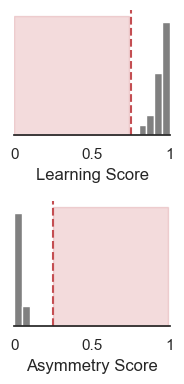

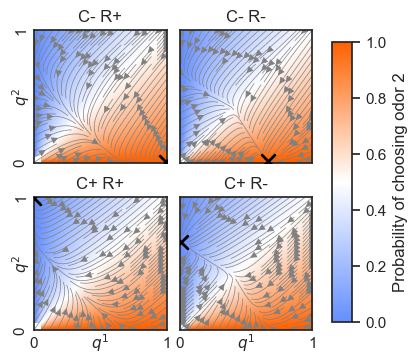

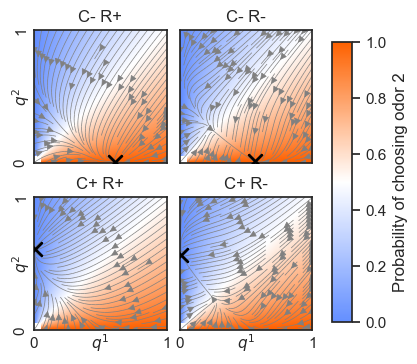

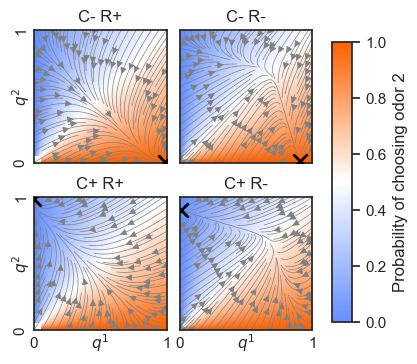

C- R+: 0.0
C- R-: 0.0
C+ R+: 0.0
C+ R-: 0.0


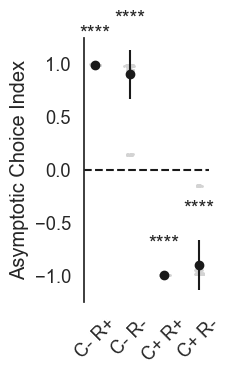

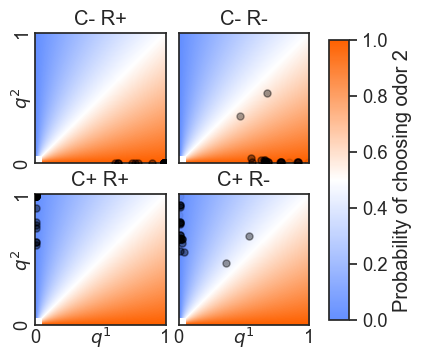

In [71]:
# symmetric GQNN analysis

def get_ar_prob(x,y):
    return np.exp(np.log(x)+np.log(3-y)-np.log(3*x+3*y-2*x*y))

# get all 2 symmetric GQNNs
subset_a = reduced_data[(reduced_data['agent'] == 'GQNN') & (reduced_data['symmetric'] == True) & (reduced_data['hidden_state_sizes'] == '2')].copy().reset_index(drop=True)

overwrite = False
# generate learning scores
if not os.path.exists('data/symFFQN2_learning_scores.csv') or overwrite:
    lr_score = pd.DataFrame(columns=['index','learning_score','asymmetry_score'])
    for i in tqdm(range(len(subset_a)),desc='Generating learning scores'):
        i, LS, AS = generate_learning_scores(subset_a,i)
        lr_score = lr_score.append({'index':i,'learning_score':LS,'asymmetry_score':AS},ignore_index=True)
    lr_score.to_csv('data/symFFQN2_learning_scores.csv',index=False)
else:
    lr_score = pd.read_csv('data/symFFQN2_learning_scores.csv')
    
# plot learning scores and asymmetry scores histograms
sns.set(font_scale=1.0,style='white')
fig, ax = plt.subplots(2,1,figsize=(2,4))
ax[0].hist(lr_score['learning_score'],bins=np.arange(0,1.1,0.05),color='grey')
ax[1].hist(lr_score['asymmetry_score'],bins=np.arange(0,1.1,0.05),color='grey')
ax[0].set_xlabel("Learning Score")
ax[1].set_xlabel("Asymmetry Score")
ax[0].axvline(x=0.75,color='r',linestyle='--')
ax[1].axvline(x=0.25,color='r',linestyle='--')
# fill area with learning score < 0.75
ax[0].fill_between(np.arange(0,0.75,0.01),0,ax[0].get_ylim()[1],color='r',alpha=0.2)
# fill area with asymmetry score > 0.25
ax[1].fill_between(np.arange(0.25,1,0.01),0,ax[1].get_ylim()[1],color='r',alpha=0.2)
for i in range(2):
    ax[i].set_ylabel("")
    ax[i].set_yticks([])
    ax[i].set_xticks([0,0.5,1])
    ax[i].set_xticklabels([0,0.5,1])
    ax[i].set_xlim(0,1)
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symFFQN2_learning_scores.pdf',bbox_inches='tight')
plt.show()

# filter out models with low learning scores and high asymmetry scores
filter_index = lr_score[(lr_score['learning_score'] > 0.75) & (lr_score['asymmetry_score'] < 0.25)]['index'].values
subset_a = subset_a.iloc[filter_index].reset_index(drop=True)


if not os.path.exists("data/symFFQN2_attractors.pkl") or overwrite:
    # get attractors
    attractors = []
    for i in tqdm(range(len(subset_a)),desc="Calculating attractors"):
        attractors.append(generate_GQNN_attractorspace(subset_a, i, 10, 200))
    # save as pickle
    with open('data/symFFQN2_attractors.pkl','wb') as f:
        pickle.dump(attractors,f)
else:
    # load with pickle
    with open('data/symFFQN2_attractors.pkl','rb') as f:
        attractors = pickle.load(f)

# clean attractors
if not os.path.exists("data/symFFQN2_attractors.csv") or overwrite:
    cleaned_attractors = pd.DataFrame(columns=['ID','x','y','condition'])
    for i in range(len(attractors)):
        for j in range(4):
            for k in range(attractors[i][j].shape[0]):
                temp = attractors[i][j][k]
                cleaned_attractors = cleaned_attractors.append({'ID':i,'x':temp[0],'y':temp[1],'condition':j},ignore_index=True)
    cleaned_attractors['CI'] = cleaned_attractors.apply(lambda x: (get_ar_prob(x['x'],x['y'])-0.5)*2,axis=1)
    cleaned_attractors['condition_names'] = cleaned_attractors['condition'].map(condition_map)
    cleaned_attractors.to_csv('data/symFFQN2_attractors.csv',index=False)
else:
    cleaned_attractors = pd.read_csv('data/symFFQN2_attractors.csv')

# get three random models
np.random.seed(123)
random_models = np.random.choice(np.arange(len(subset_a)),3,replace=False)

# plot attractors on value fields
for j in random_models:
    X,Y,U,V,z,AR = generate_GQNN_valuefield(subset_a, j, 50)
    fig,ax=plot_GQNN_valuefield(X,Y,U,V,z,AR,arrow=False,flow_color='gray',flow_density=1.2,show=False,figsize=(4,4),font_scale=1,flow_width=0.5)
    # plot attractors
    for i in range(4):
        dat = cleaned_attractors[(cleaned_attractors['ID'] == j) & (cleaned_attractors['condition'] == i)]
        ax.flat[i].scatter(dat['x'],dat['y'],color='#000000',s=100,marker='x',zorder=10,alpha=0.5)
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig('figures/symFFQN2_{}_field.pdf'.format(j),bbox_inches='tight')
    plt.show()
    


# error bar plot
sns.set(font_scale=1.2,style='white')
fig,ax = plt.subplots(1,1,figsize=(2.5,4))
i = 0
for cond in cleaned_attractors['condition_names'].unique():
    dat = cleaned_attractors[cleaned_attractors['condition_names'] == cond]
    ax.errorbar(i,dat['CI'].mean(),yerr=dat['CI'].std(),fmt='o',color='k')
    ax.scatter(i+0.05*np.random.randn(len(dat)),dat['CI'],color='lightgray',s=1,alpha=1)
    # fraction of attractors with CI > 0 or CI < 0
    p_val = np.min([np.mean(dat['CI'] > 0),np.mean(dat['CI'] < 0)])
    print("{}: {}".format(cond,p_val))
    p_val = pvalue_to_stars(p_val)
    ax.text(i,dat['CI'].mean()+dat['CI'].std()+0.2,p_val,ha='center',va='bottom')
    i += 1
ax.axhline(y=0,color='k',linestyle='--')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cleaned_attractors['condition_names'].unique(),rotation=45)
ax.set_ylabel('Asymptotic Choice Index')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symFFQN2_attractor_CI.pdf',bbox_inches='tight')
plt.show()

fig,ax=plot_GQNN_valuefield(X,Y,U,V,z,AR,arrow=False,flow=False,show=False,figsize=(4,4),font_scale=1.2)
# plot all attractors
for i in range(4):
    ax.flat[i].scatter(cleaned_attractors[cleaned_attractors['condition'] == i]['x'],cleaned_attractors[cleaned_attractors['condition'] == i]['y'],color='#000000',s=100,marker='.',zorder=10,alpha=0.05)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig('figures/symFFQN2_attractorfield.pdf',bbox_inches='tight')
plt.show()

## RQN Analysis

In [76]:
# get all 2 symmetric GRNNs
subset_s = reduced_data[(reduced_data['agent'] == 'GRNN') & (reduced_data['symmetric'] == True) & (reduced_data['reservoir_size'] == 2)].copy().reset_index(drop=True)

In [117]:
# prepare the model and environment
def get_model_fom_entry(dataset,index,model_directory="../../FlYMazeRL_Fits/nn/mohanta2022/"):
    env = ymaze_static(None, None)
    model_type = dataset['agent'][0]

    # create learner parameters
    learner_params = {
        "allow_negative_values": False,
        "symmetric_q_function": dataset['symmetric'][0],
        "omission_is_punishment": False,
        "policy_type": 'acceptreject',
        "device": 'cpu',
        "pre_trained": False,
        "model_path": None,
        "multi_agent": False,
        "n_agents": 1,
    }
    if dataset.agent[0] == "GQNN":
        learner_params["hidden_state_sizes"] = [int(x) for x in dataset['hidden_state_sizes'][0].split('x')]
        learner_params["activation"] = "relu"
        learner = GQLearner(env,learner_params)
    elif dataset.agent[0] == "GRNN":
        learner_params["encoder_size"] = None
        learner_params["num_layers"] = 1
        learner_params["reservoir_size"] = int(dataset['reservoir_size'][0])
        learner_params["kind"] = 'RNN'
        learner = GRNNLearner(env, learner_params)

    entry = dataset.iloc[index]
    model_id = entry['ModelID']
    path = entry['Model Path']
    model_path = model_directory + f"{model_id}/{path}.pt"

    # load model
    learner.load_pre_trained_model(model_path)
    return learner


In [118]:
# Load Training Data
training_choice_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/training_choice_set.csv', delimiter=',')
training_reward_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/training_reward_set.csv', delimiter=',')
# Load Test Data
test_choice_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/test_choice_set.csv', delimiter=',')
test_reward_set = np.loadtxt('../../../FlYMazeRL/data/mohanta2022/test_reward_set.csv', delimiter=',')


In [119]:
from sklearn.decomposition import PCA

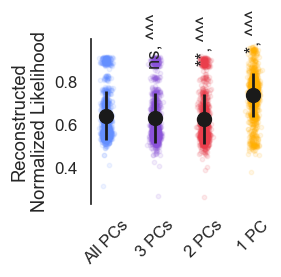

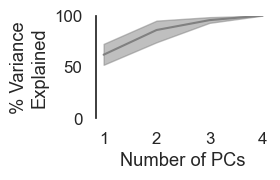

In [120]:
true_lls = []
l1_lls = []
l2_lls = []
l3_lls = []
variance_explained = []
true_preds = []
l1_preds = []
l2_preds = []
l3_preds = []

for i in range(len(subset_s)):
    learner = get_model_fom_entry(subset_s,i)
    dataset = torch.tensor(np.array([test_choice_set, test_reward_set]).transpose((1, 2, 0))).float()
    X = torch.clone(dataset[:, :-1, :])
    X[:, :, 0] = X[:, :, 0] * 2 - 1
    
    hidden = learner.agent.init_hidden(X.shape[0])
    true_out, h_dynamics = learner.agent.forward(X,hidden,get_hidden_dynamics=True)

    # calculate prediction and log likelihood
    true_pred = np.array([accept_reject_policy(x).detach().numpy() for x in true_out])
    true_ll = np.exp(np.mean(test_choice_set[:,:-1] * np.log(true_pred) + (1 - test_choice_set[:,:-1]) * np.log(1 - true_pred), axis=1))
    true_lls.append(true_ll)
    true_preds.append(true_pred)

    # calculate PCA variance explained
    variance_explained.append(np.cumsum(PCA(n_components=4).fit(h_dynamics.reshape(-1,4)).explained_variance_ratio_))

    
    for j in range(1,4):
        filter_pca = PCA(n_components=j)
        pcs = filter_pca.fit_transform(h_dynamics.reshape(-1,4))
        # inverse transform
        filtered_h_dynamics = filter_pca.inverse_transform(pcs).reshape(-1,159,4)
        test_out = learner.agent.decode_hidden_dynamics(torch.tensor(filtered_h_dynamics).float())
        # calculate probabilities
        test_pred = np.array([accept_reject_policy(x).detach().numpy() for x in test_out])
        # calculate true normalized likelihood
        test_ll = np.exp(np.mean(test_choice_set[:,:-1] * np.log(test_pred) + (1 - test_choice_set[:,:-1]) * np.log(1 - test_pred), axis=1))
        if j == 1:
            l1_lls.append(test_ll)
            l1_preds.append(test_pred)
        elif j == 2:
            l2_lls.append(test_ll)
            l2_preds.append(test_pred)
        elif j == 3:
            l3_lls.append(test_ll)
            l3_preds.append(test_pred)

# convert to numpy 
true_lls = np.array(true_lls)
l1_lls = np.array(l1_lls)
l2_lls = np.array(l2_lls)
l3_lls = np.array(l3_lls)
variance_explained = np.array(variance_explained)
true_preds = np.array(true_preds)
l1_preds = np.array(l1_preds)
l2_preds = np.array(l2_preds)
l3_preds = np.array(l3_preds)

ps = []
effs = [] 

# significance
for i,group in enumerate([l3_lls,l2_lls,l1_lls]):
    p_vals = []
    for j in range(true_lls.shape[0]):
        p_vals.append(stats.wilcoxon(group[j,:],true_lls[j,:]).pvalue)
    p_val = np.quantile(p_vals,0.95)
    ps.append(p_val)
    effs.append(pairedRankBiserialCorrelation(true_lls,group))

most_affected_models = np.argsort(np.mean(true_lls - l3_lls,axis=1))
most_affected_fly = np.argsort(np.mean(true_lls - l3_lls,axis=0))

# flatten
true_lls = true_lls.flatten()
l1_lls = l1_lls.flatten()
l2_lls = l2_lls.flatten()
l3_lls = l3_lls.flatten()

# plot
sns.set(style='white',font_scale=1.1)
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(np.random.normal(size=len(true_lls),scale=0.05),true_lls,alpha=0.1,s=10,color=cmap(0.))
ax.scatter(1+np.random.normal(size=len(l3_lls),scale=0.05),l3_lls,alpha=0.1,s=10,color=cmap(0.3))
ax.scatter(2+np.random.normal(size=len(l2_lls),scale=0.05),l2_lls,alpha=0.1,s=10,color=cmap(0.6))
ax.scatter(3+np.random.normal(size=len(l1_lls),scale=0.05),l1_lls,alpha=0.1,s=10,color=cmap(1.))

# significance
ax.text(3,np.max(l1_lls)+0.07,pvalue_to_stars(ps[2])+', '+r_to_effect(effs[2]),ha='center',va='center',rotation=90)
ax.text(2,np.max(l2_lls)+0.07,pvalue_to_stars(ps[1])+', '+r_to_effect(effs[1]),ha='center',va='center',rotation=90)
ax.text(1,np.max(l3_lls)+0.07,pvalue_to_stars(ps[0])+', '+r_to_effect(effs[0]),ha='center',va='center',rotation=90)


ax.errorbar([0,1,2,3],np.array([true_lls,l3_lls,l2_lls,l1_lls]).mean(axis=1),yerr=np.array([true_lls,l3_lls,l2_lls,l1_lls]).std(axis=1),color='k', linestyle='None', marker='o',elinewidth=2,markersize=10)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['All PCs','3 PCs','2 PCs','1 PC'],rotation=45)
ax.set_ylabel('Reconstructed\nNormalized Likelihood')
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_pca_dropout.pdf',bbox_inches='tight')
plt.show()

# plot variance explained
sns.set(style='white',font_scale=1.1)
fig,ax = plt.subplots(1,1,figsize=(3,2))
ax.plot(np.arange(1,5),np.mean(variance_explained,axis=0)*100,color='gray')
ax.fill_between(np.arange(1,5),np.quantile(variance_explained,0.05,axis=0)*100,np.quantile(variance_explained,0.95,axis=0)*100,color='gray',alpha=0.5)
ax.set_xlabel('Number of PCs')
ax.set_xticks([1,2,3,4])
ax.set_ylabel('% Variance\nExplained')
ax.set_ylim(0,100)
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_variance.pdf',bbox_inches='tight')
plt.show()

In [121]:
# get three random flies
np.random.seed(123)
random_flies =  most_affected_fly[-3:] #np.random.choice(training_choice_set.shape[0],3,replace=False)

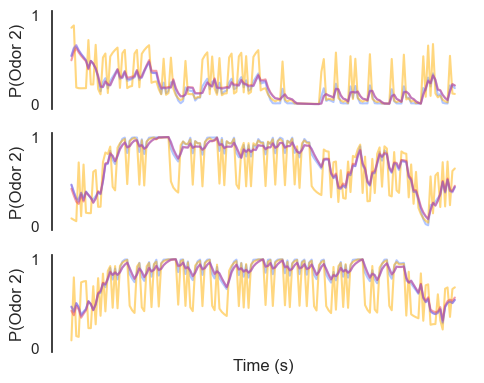

In [122]:
sns.set(style='white',font_scale=1)
fig,ax = plt.subplots(3,1,figsize=(5,4),sharex=True,sharey=True)
worst_fly = most_affected_fly[-3:]
worst_model = most_affected_models[-1]
for i in range(3):
    ax[i].plot(true_preds[worst_model,worst_fly[i],:],color=cmap(0.),zorder=10,alpha=0.5)
    ax[i].plot(l1_preds[worst_model,worst_fly[i],:],color=cmap(1.),zorder=10,alpha=0.5)
    ax[i].plot(l2_preds[worst_model,worst_fly[i],:],color=cmap(0.6),zorder=10,alpha=0.5)
    ax[i].plot(l3_preds[worst_model,worst_fly[i],:],color=cmap(0.3),zorder=10,alpha=0.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([0,1])
    ax[i].set_ylabel('P(Odor 2)')
    if i == 2:
        ax[i].set_xlabel('Time (s)')
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_pca_dropout_worst.pdf',bbox_inches='tight')
plt.show()


In [125]:
pca_hidden = []
predictions = []
for i in range(len(subset_s)):
    learner = get_model_fom_entry(subset_s,i)
    dataset = torch.tensor(np.array([test_choice_set, test_reward_set]).transpose((1, 2, 0))).float()
    X = torch.clone(dataset[:, :-1, :])
    X[:, :, 0] = X[:, :, 0] * 2 - 1

    hidden = learner.agent.init_hidden(X.shape[0])
    true_out, h_dynamics = learner.agent.forward(X,hidden,get_hidden_dynamics=True)
    true_pred = np.array([accept_reject_policy(x).detach().numpy() for x in true_out])
    predictions.append(true_pred)

    # plot PCA hidden dynamics
    pca = PCA(n_components=4)
    pcs = pca.fit_transform(h_dynamics.reshape(-1,4))
    pca_hidden.append(pcs)

pca_hidden = np.array(pca_hidden)
predictions = np.array(predictions)

# realign PCA to be consistent across models
for i in range(4):
    reference = pca_hidden[0,:,i]
    for j in range(1,len(pca_hidden)):
        if np.corrcoef(pca_hidden[j,:,i],reference)[0,1] < 0:
            pca_hidden[j,:,i] = -pca_hidden[j,:,i]

# reshape
pca_hidden = pca_hidden.reshape(25,-1,159,4)

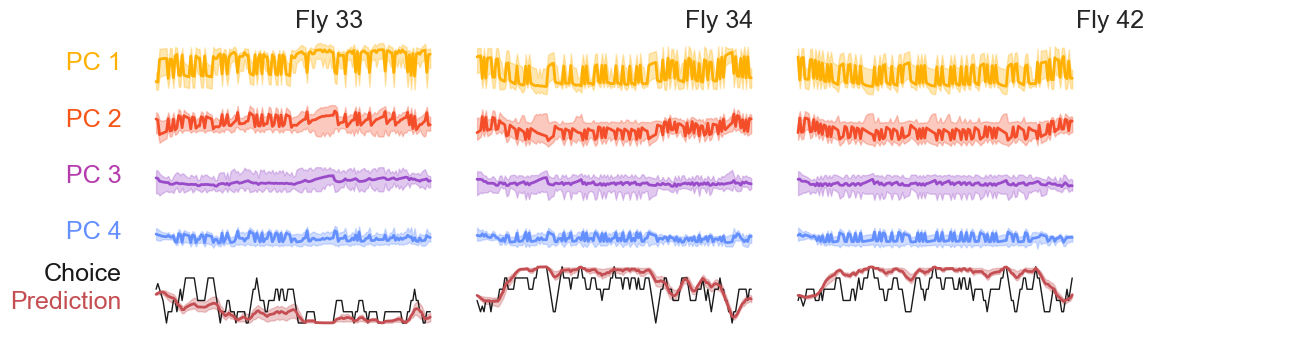

In [126]:
# plot
sns.set(style='white',font_scale=1.5)
fig,ax = plt.subplots(1,1,figsize=(15,4))
for n,i in enumerate(random_flies):
    for j in range(4):
        x = np.arange(185*n,185*(n+1)-26)
        ax.fill_between(x,np.quantile(pca_hidden[:,i,:,j],0.975,axis=0)-4*j,np.quantile(pca_hidden[:,i,:,j],0.025,axis=0)-4*j,color=cmap(1-j/3),alpha=0.3)
        ax.plot(x,np.mean(pca_hidden[:,i,:,j],axis=0)-4*j,linewidth=2,color=cmap(1-j/3))
    ax.text(225*n+80,3,'Fly {}'.format(i+1))
    # plot choice
    ax.plot(x,smoothen(test_choice_set[i,:-1],5)*4-18,color='k',linewidth=1)
    # plot prediction
    ax.plot(x,np.mean(smoothen(predictions[:,i,:],5),axis=0)*4-18,color='r',linewidth=2)
    ax.fill_between(x,np.quantile(smoothen(predictions[:,i,:],5),0.975,axis=0)*4-18,np.quantile(smoothen(predictions[:,i,:],5),0.025,axis=0)*4-18,color='r',alpha=0.3)
ax.text(-20,-4*3,'PC 4',color=cmap(0.),ha ='right')
ax.text(-20,-4*2,'PC 3',color=cmap(0.4),ha ='right')
ax.text(-20,-4*1,'PC 2',color=cmap(0.7),ha ='right')
ax.text(-20,-4*0,'PC 1',color=cmap(1.),ha ='right')
ax.text(-20,-4*4+1,'Choice',color='k',ha ='right')
ax.text(-20,-4*4-1,'Prediction',color='r',ha ='right')
ax.set_xlim(-20,225*3-25)
plt.box(False)
plt.xticks([])
plt.yticks([])
# turn off all the ticks
plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
plt.savefig('figures/symRQN_pcas.pdf',bbox_inches='tight')
plt.show()

In [127]:
from scipy.optimize import curve_fit

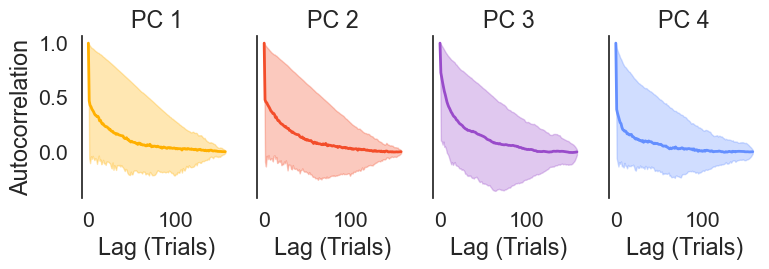

In [128]:
# plot autocorrelation
sns.set(style='white',font_scale=1.4)
fig,ax = plt.subplots(1,4,figsize=(8,3),sharex=True,sharey=True)
taus = []
for i in range(4):
    corrs = []
    tau= []
    for j,k in product(range(len(subset_s)),range(len(test_choice_set))):
        x = pca_hidden[j,k,:,i]
        corr = np.correlate(x,x,mode='full')
        corr = corr[int(len(corr)/2):]
        # get half time
        half = np.argmax(corr < np.max(corr)/2)
        tau.append(half)
        corrs.append(corr)
    corrs = np.array(corrs)
    normalized_corrs = corrs/np.max(corrs,axis=1)[:,None]
    # plot mean and 95% CI
    ax[i].plot(np.mean(normalized_corrs,axis=0),color=cmap(1-i/3),linewidth=2)
    ax[i].fill_between(np.arange(len(normalized_corrs[0])),np.quantile(normalized_corrs,0.025,axis=0),np.quantile(normalized_corrs,0.975,axis=0),color=cmap(1-i/3),alpha=0.3)
    ax[i].set_xlabel('Lag (Trials)')
    if i == 0:
        ax[i].set_ylabel('Autocorrelation')
    ax[i].set_title('PC {}'.format(i+1))
    taus.append(np.array(tau).reshape(len(subset_s),len(test_choice_set)))
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_autocorrelation.pdf',bbox_inches='tight')
plt.show()
taus = np.array(taus)

PC 1 vs PC 2: p = 0.22821684852821128
Effect size: -0.024782969268014987
PC 1 vs PC 3: p = 0.7632849606757857
Effect size: -0.265276123114895
PC 1 vs PC 4: p = 0.007170471075268305
Effect size: 0.32668506740269615


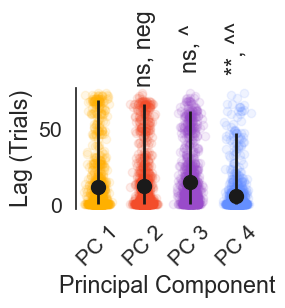

In [129]:
# plot mean tau
sns.set(style='white',font_scale=1.4)
fig,ax = plt.subplots(1,1,figsize=(3,4))
for i in range(4):
    t = taus[i].flatten()
    ax.scatter((i+1) + np.random.normal(0,0.1,len(t)),t,color=cmap(1-i/3),alpha=0.1)
    ax.errorbar([i+1],[np.mean(t)],yerr=[[np.mean(t)-np.quantile(t,0.025)],[np.quantile(t,0.975)-np.mean(t)]],color='k',marker='o',markersize=10,linewidth=2)
    if i == 0:
        pc1 = taus[i]
    else:
        # perform statistical tests
        ps = []
        for j in range(len(subset_s)):
            ps.append(stats.wilcoxon(pc1[j,:],taus[i,j,:])[1])
        ps = np.quantile(ps,0.95)
        print('PC 1 vs PC {}: p = {}'.format(i+1,ps))
        eff = pairedRankBiserialCorrelation(pc1.flatten(),taus[i].flatten())
        print('Effect size: {}'.format(eff))
        ax.text(i+1,np.max(t)+30,pvalue_to_stars(ps)+', '+r_to_effect(eff),ha='center',va='center',rotation=90)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['PC 1','PC 2','PC 3','PC 4'],rotation=45)
ax.set_ylabel('Lag (Trials)')
ax.set_xlabel('Principal Component')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_autocorrelation_mean.pdf',bbox_inches='tight')
plt.show()

In [130]:
# perform statistical moment regression
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import PolynomialFeatures

In [131]:
def rolling_window(a, window, pad = 0, predictive=True):
    if len(a.shape) == 1:
        # add padding
        if pad is not None:
            a = np.concatenate([np.ones(window-1+predictive)*pad,a])
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    elif len(a.shape) == 2:
        aa = []
        for i in range(a.shape[0]):
            aa.append(rolling_window(a[i,:],window,pad,predictive))
        return np.array(aa)
    elif len(a.shape) == 3:
        aa = []
        for i in range(a.shape[0]):
            aa.append(rolling_window(a[i,:,:],window,pad,predictive))
        return np.array(aa)
    elif len(a.shape) == 4:
        aa = []
        for i in range(a.shape[0]):
            aa.append(rolling_window(a[i,:,:,:],window,pad,predictive))
        return np.array(aa)
    else:
        raise ValueError('Array must be 1, 2, 3, or 4 dimensions')

def generate_poly(x,y,degree=2,allow_interactions=True,allow_equal_interactions=True):
    full = []
    name = ""
    for i in range(1,degree+1):
        full.append(x**i)
        name += "x^{} + ".format(i)
    for i in range(1,degree+1):
        full.append(y**i)
        name += "y^{} + ".format(i)
    if allow_interactions:
        for i in range(1,degree+1):
            for j in range(1,degree+1):
                if allow_equal_interactions:
                    if i+j <= degree+1:
                        full.append(x**i*y**j)
                        name += "x^{}y^{} + ".format(i,j)
                else:
                    if i+j <= degree:
                        full.append(x**i*y**j)
                        name += "x^{}y^{} + ".format(i,j)
    name = name[:-3]
    return full,name


In [132]:
pca_hidden = []
pca_models = []
predictions = []
true_hidden = []
for i in range(len(subset_s)):
    learner = get_model_fom_entry(subset_s,i)
    dataset = torch.tensor(np.array([test_choice_set, test_reward_set]).transpose((1, 2, 0))).float()
    X = torch.clone(dataset[:, :-1, :])
    X[:, :, 0] = X[:, :, 0] * 2 - 1

    hidden = learner.agent.init_hidden(X.shape[0])
    true_out, h_dynamics = learner.agent.forward(X,hidden,get_hidden_dynamics=True)
    true_pred = np.array([accept_reject_policy(x).detach().numpy() for x in true_out])
    predictions.append(true_pred)
    true_hidden.append(h_dynamics.reshape(-1,4).detach().numpy())

    # plot PCA hidden dynamics
    pca = PCA(n_components=4)
    pcs = pca.fit_transform(h_dynamics.reshape(-1,4).detach().numpy())
    pca_hidden.append(pcs)
    pca_models.append(pca)

pca_hidden = np.array(pca_hidden)
predictions = np.array(predictions)
true_hidden = np.array(true_hidden).reshape(len(subset_s),-1,159,4)

# realign PCA to be consistent across models
correction_tracker = np.ones_like(pca_hidden)
for i in range(4):
    reference = pca_hidden[0,:,i]
    for j in range(1,len(pca_hidden)):
        if np.corrcoef(pca_hidden[j,:,i],reference)[0,1] < 0:
            correction_tracker[j,:,i] = -correction_tracker[j,:,i]

# pca_hidden = pca_hidden*correction_tracker

# reshape
pca_hidden = pca_hidden.reshape(len(subset_s),-1,159,4)

window = 80
choices = (rolling_window(test_choice_set,window,0.5)[:,:-2,:].reshape(-1,window)-0.5) *2
rewards = rolling_window(test_reward_set,window,0)[:,:-2,:].reshape(-1,window)
poly,poly_name = generate_poly(choices,rewards,degree=1)
X = np.concatenate(poly,axis=1)
print(poly_name)
lin_pcas = []
lin_models = []
scores = []

for i in range(len(subset_s)):
    lms = []
    prds = []
    for j in range(4):
        y = pca_hidden[i,:,:,j].flatten()
        # fit model
        model = LinearRegression()
        model.fit(X,y)
        prd = model.predict(X)
        score = model.score(X,y)
        scores.append(score)
        lms.append(model)
        prds.append(prd.reshape(1,-1,159,1))
    lin_pcas.append(np.concatenate(prds,axis=3))
    lin_models.append(lms)

lin_pcas = np.concatenate(lin_pcas,axis=0)
scores = np.array(scores).reshape(len(subset_s),-1).T

x^1 + y^1 + x^1y^1


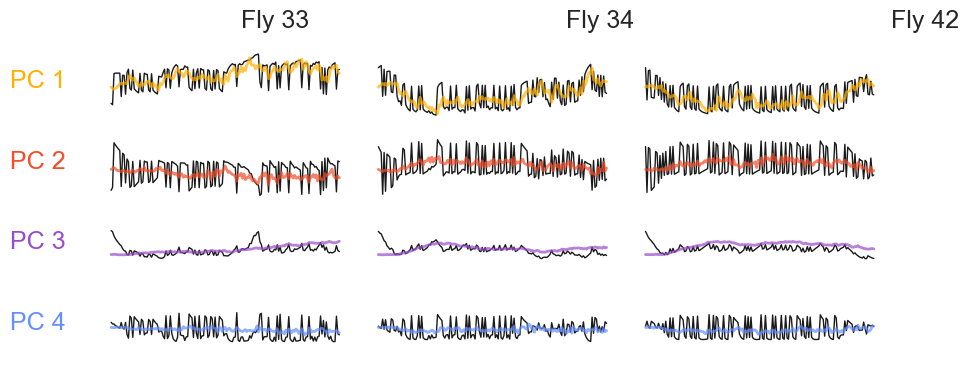

In [133]:
# plot
index = most_affected_models[-1]
sns.set(style="white",font_scale=1.5)
fig,ax = plt.subplots(1,1,figsize=(10,4))
for i in range(4):
    for n,j in enumerate(random_flies):
        x = np.arange(185*n,185*(n+1)-26)
        ax.plot(x,lin_pcas[index,j,:,i].flatten()-4*i,zorder=10,linewidth=2,alpha=0.7,color=cmap(1-i/3))
        ax.plot(x,pca_hidden[index,j,:,i].flatten()-4*i,alpha=1,color='k',zorder=0,linewidth=1)
        if i == 0:
            ax.text(225*n+90,3,"Fly {}".format(j+1))
    ax.text(-70,-4*i,"PC {}".format(i+1),color=cmap(1-i/3))
for sp in ax.spines.values():
    sp.set_visible(False)
ax.set_xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("figures/symRQN_pca_linearreconstruction.pdf")
plt.show()

PC 1 vs PC 2: p = 0.8531995415687561
Effect size: -0.046153846153846156
PC 1 vs PC 3: p = 0.0014527440071105957
Effect size: 0.6984615384615385
PC 1 vs PC 4: p = 3.2782554626464844e-06
Effect size: 0.9323076923076923


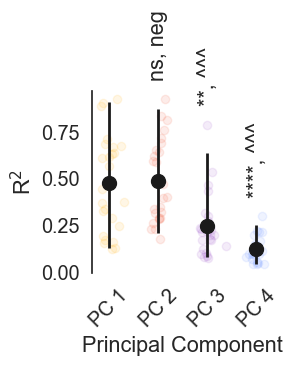

In [134]:

# plot scores
sns.set(style='white',font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(3,4))
for i in range(4):
    t = scores[i].flatten()
    ax.scatter((i+1) + np.random.normal(0,0.1,len(t)),t,color=cmap(1-i/3),alpha=0.1)
    ax.errorbar([i+1],[np.mean(t)],yerr=[[np.mean(t)-np.quantile(t,0.025)],[np.quantile(t,0.975)-np.mean(t)]],color='k',marker='o',markersize=10,linewidth=2)
    if i == 0:
        pc1 = scores[i]
    else:
        # perform statistical tests
        ps = stats.wilcoxon(pc1,scores[i,:])[1]
        print('PC 1 vs PC {}: p = {}'.format(i+1,ps))
        eff = pairedRankBiserialCorrelation(pc1.flatten(),scores[i].flatten())
        print('Effect size: {}'.format(eff))
        ax.text(i+1,np.max(t)+0.1,pvalue_to_stars(ps)+', '+r_to_effect(eff),ha='center',va='bottom',rotation=90)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['PC 1','PC 2','PC 3','PC 4'],rotation=45)
ax.set_ylabel(f'R$^2$')
ax.set_xlabel('Principal Component')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_linear_scores.pdf')
plt.show()

In [135]:
# find inverses
recovered_hidden = []
for i,model in enumerate(pca_models):
    recovered_hidden.append(model.inverse_transform(lin_pcas[i].reshape(-1,4)))
recovered_hidden = np.array(recovered_hidden).reshape(len(subset_s),-1,159,4)

# reapply correction
recovered_hidden = recovered_hidden#*correction_tracker.reshape(len(subset_s),-1,159,4)

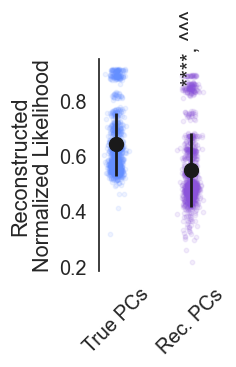

In [136]:
true_lls = []
test_lls = []
true_preds = []
test_preds = []

for i in range(len(subset_s)):
    learner = get_model_fom_entry(subset_s,i)
    dataset = torch.tensor(np.array([test_choice_set,test_reward_set]).transpose((1, 2, 0))).float()
    X = torch.clone(dataset[:, :-1, :])
    X[:, :, 0] = X[:, :, 0] * 2 - 1
    
    hidden = learner.agent.init_hidden(X.shape[0])
    true_out, h_dynamics = learner.agent.forward(X,hidden,get_hidden_dynamics=True)

    # calculate prediction and log likelihood
    true_pred = np.array([accept_reject_policy(x).detach().numpy() for x in true_out])
    true_ll = np.exp(np.mean(test_choice_set[:,:-1] * np.log(true_pred) + (1 - test_choice_set[:,:-1]) * np.log(1 - true_pred), axis=1))
    true_lls.append(true_ll)
    true_preds.append(true_pred)

    filtered_h_dynamics = recovered_hidden[i]

    # recover logits using recovered hidden dynamics
    test_out = learner.agent.decode_hidden_dynamics(torch.tensor(filtered_h_dynamics).float())
    
    # calculate probabilities
    test_pred = np.array([accept_reject_policy(x).detach().numpy() for x in test_out])

    # calculate true normalized likelihood
    test_ll = np.exp(np.mean(test_choice_set[:,:-1] * np.log(test_pred) + (1 - test_choice_set[:,:-1]) * np.log(1 - test_pred), axis=1))
    test_lls.append(test_ll)
    test_preds.append(test_pred)

true_lls = np.array(true_lls)
test_lls = np.array(test_lls)
true_preds = np.array(true_preds)
test_preds = np.array(test_preds)

ps = []
effs = [] 

# significance
for i,group in enumerate([test_lls]):
    p_vals = []
    for j in range(true_lls.shape[0]):
        p_vals.append(stats.wilcoxon(group[j,:],true_lls[j,:]).pvalue)
    p_val = np.quantile(p_vals,0.95)
    ps.append(p_val)
    effs.append(pairedRankBiserialCorrelation(true_lls,group))


ps = ps[0]
effs = effs[0]

true_lls = true_lls.flatten()
test_lls = test_lls.flatten()

# plot
sns.set(style='white',font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(2.5,4))
ax.scatter(np.random.normal(size=len(true_lls),scale=0.05),true_lls,alpha=0.1,s=10,color=cmap(0.))
ax.scatter(1+np.random.normal(size=len(test_lls),scale=0.05),test_lls,alpha=0.1,s=10,color=cmap(0.3))

# significance
ax.text(1,np.max(test_lls)+0.1,pvalue_to_stars(ps)+', '+r_to_effect(effs),ha='center',va='center',rotation=90)

ax.errorbar([0,1],np.array([true_lls,test_lls]).mean(axis=1),yerr=np.array([true_lls,test_lls]).std(axis=1),color='k', linestyle='None', marker='o',elinewidth=2,markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['True PCs','Rec. PCs'],rotation=45)
ax.set_ylabel('Reconstructed\nNormalized Likelihood')
# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('figures/symRQN_pca_reconstruction_summary.pdf',bbox_inches='tight')
plt.show()

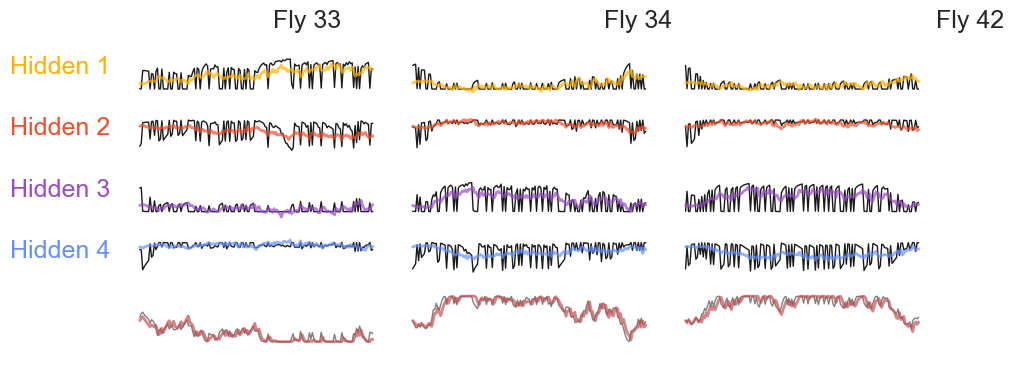

In [137]:
# plot
index = most_affected_models[-1]
sns.set(style="white",font_scale=1.5)
fig,ax = plt.subplots(1,1,figsize=(10.5,4))
for i in range(4):
    for n,j in enumerate(random_flies):
        x = np.arange(185*n,185*(n+1)-26)
        ax.plot(x,recovered_hidden[index,j,:,i].flatten()-4*i,zorder=10,linewidth=2,alpha=0.7,color=cmap(1-i/3))
        ax.plot(x,true_hidden[index,j,:,i].flatten()-4*i,alpha=1,color='k',zorder=0,linewidth=1)
        if i == 0:
            ax.text(225*n+90,3,"Fly {}".format(j+1))
    ax.text(-20,-4*i,"Hidden {}".format(i+1),color=cmap(1-i/3),ha='right')

for n,j in enumerate(random_flies):
    # plot predictions
    x = np.arange(185*n,185*(n+1)-26)
    ax.plot(x,(true_preds[index,j,:]-0.5)*3-4*4,alpha=1,color='gray',zorder=0,linewidth=1)
    ax.plot(x,(test_preds[index,j,:]-0.5)*3-4*4,zorder=10,linewidth=2,alpha=0.7,color='r')
    if j == 0:
        ax.text(-20,-4*4-1.5,"Rec. CI",color='r',ha='right')
        ax.text(-20,-4*4,"True CI",color='gray',ha='right')


for sp in ax.spines.values():
    sp.set_visible(False)
ax.set_xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/symRQN_hidden_reconstruction.pdf',bbox_inches='tight')
plt.show()

In [111]:
correction = correction_tracker.mean(axis=1)
correction = correction[np.newaxis,:,:]

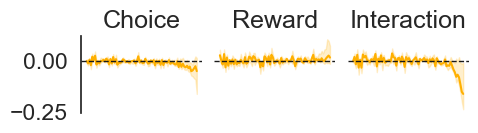

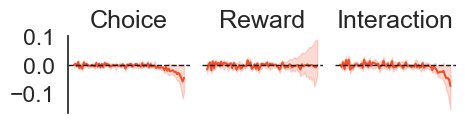

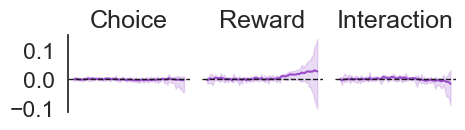

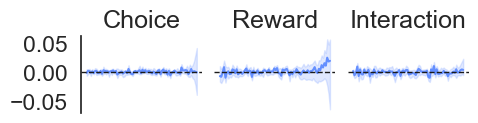

In [113]:
coefs = np.array([[j.coef_ for j in lin_models[i]] for i in range(len(lin_models))])
choice_coefs = coefs[:,:,:window]
reward_coefs = coefs[:,:,window:2*window]
interaction_coefs = coefs[:,:,2*window:]

correction = correction_tracker.mean(axis=1)
correction = correction[np.newaxis,:,:]

choice_coefs = (choice_coefs.transpose(2,0,1)*correction).transpose(1,2,0)
reward_coefs = (reward_coefs.transpose(2,0,1)*correction).transpose(1,2,0)
interaction_coefs = (interaction_coefs.transpose(2,0,1)*correction).transpose(1,2,0)

# plot
for i in range(4):
    color = cmap(1-i/3)
    fig,ax = plt.subplots(1,3,figsize=(5,1),sharex=True,sharey=True)
    ax[0].plot(np.mean(choice_coefs[:,i,:],axis=0),color=color)
    ax[0].fill_between(np.arange(window),np.quantile(choice_coefs[:,i,:],0.025,axis=0),np.quantile(choice_coefs[:,i,:],0.975,axis=0),alpha=0.2,color=color)
    ax[0].set_title('Choice')
    ax[1].plot(np.mean(reward_coefs[:,i,:],axis=0),color=color)
    ax[1].fill_between(np.arange(window),np.quantile(reward_coefs[:,i,:],0.025,axis=0),np.quantile(reward_coefs[:,i,:],0.975,axis=0),alpha=0.2,color=color)
    ax[1].set_title('Reward')
    ax[2].plot(np.mean(interaction_coefs[:,i,:],axis=0),color=color)
    ax[2].fill_between(np.arange(window),np.quantile(interaction_coefs[:,i,:],0.025,axis=0),np.quantile(interaction_coefs[:,i,:],0.975,axis=0),alpha=0.2,color=color)
    ax[2].set_title('Interaction')
    for j in range(3):
        for spine in ax[j].spines.values():
            spine.set_visible(False)
        ax[j].set_xticks([])
        ax[j].axhline(0,color='k',linewidth=1,linestyle='--')
        if j ==0:
            ax[j].spines['left'].set_visible(True)
    plt.subplots_adjust(wspace=0.1)
    plt.savefig('figures/symRQN_pc_{}_coefs.pdf'.format(i+1),bbox_inches='tight')
    plt.show()


In [77]:
pca_hidden = []
pca_models = []
predictions = []
true_hidden = []
for i in range(len(subset_s)):
    learner = get_model_fom_entry(subset_s,i)
    dataset = torch.tensor(np.array([training_choice_set, training_reward_set]).transpose((1, 2, 0))).float()
    X = torch.clone(dataset[:, :-1, :])
    X[:, :, 0] = X[:, :, 0] * 2 - 1

    hidden = learner.agent.init_hidden(X.shape[0])
    true_out, h_dynamics = learner.agent.forward(X,hidden,get_hidden_dynamics=True)
    true_pred = np.array([accept_reject_policy(x).detach().numpy() for x in true_out])
    predictions.append(true_pred)
    true_hidden.append(h_dynamics.reshape(-1,4).detach().numpy())

    # plot PCA hidden dynamics
    pca = PCA(n_components=4)
    pcs = pca.fit_transform(h_dynamics.reshape(-1,4).detach().numpy())
    pca_hidden.append(pcs)
    pca_models.append(pca)

pca_hidden = np.array(pca_hidden)
predictions = np.array(predictions)
true_hidden = np.array(true_hidden).reshape(len(subset_s),-1,199,4)

# realign PCA to be consistent across models
correction_tracker = np.ones_like(pca_hidden)
for i in range(4):
    reference = pca_hidden[0,:,i]
    for j in range(1,len(pca_hidden)):
        if np.corrcoef(pca_hidden[j,:,i],reference)[0,1] < 0:
            correction_tracker[j,:,i] = -correction_tracker[j,:,i]

# pca_hidden = pca_hidden*correction_tracker

# reshape
pca_hidden = pca_hidden.reshape(len(subset_s),-1,199,4)

window = 80
choices = (rolling_window(training_choice_set,window,0.5)[:,:-2,:].reshape(-1,window)-0.5) *2
rewards = rolling_window(training_reward_set,window,0)[:,:-2,:].reshape(-1,window)
poly,poly_name = generate_poly(choices,rewards,degree=1)
X = np.concatenate(poly,axis=1)
print(poly_name)
lin_pcas = []
lin_models = []
scores = []

for i in range(len(subset_s)):
    lms = []
    prds = []
    for j in range(4):
        y = pca_hidden[i,:,:,j].flatten()
        # fit model
        model = LinearRegression()
        model.fit(X,y)
        prd = model.predict(X)
        score = model.score(X,y)
        scores.append(score)
        lms.append(model)
        prds.append(prd.reshape(1,-1,199,1))
    lin_pcas.append(np.concatenate(prds,axis=3))
    lin_models.append(lms)

lin_pcas = np.concatenate(lin_pcas,axis=0)
scores = np.array(scores).reshape(len(subset_s),-1).T

x^1 + y^1 + x^1y^1


In [102]:
rolling_window(pca_hidden.transpose(0,1,3,2),10,0).transpose(0,1,3,4,2)[2,:,:-2,:,:].reshape(-1,10,4).shape

(3564, 10, 4)

In [41]:
# metric = "LogLikelihood"



# # find the minimum value of the metric
# min_val = reduced_data[f"{metric}(train)"].min()
# # find the maximum value of the metric
# max_val = reduced_data[f"{metric}(train)"].max()

# for agent in ["GRNN", "GQNN"]:
#     for sym in [True,False]:
#         # set fontsize
#         plt.rcParams.update({'font.size': 14})

#         sub_df = full_data[full_data['agent'] == agent]
#         sub_df = sub_df[sub_df['symmetric'] == sym]
#         sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

#         fig, ax = plt.subplots(figsize=(4,4) if agent == "GRNN" else (7,4))

#         var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
#         order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

#         # plot training error
#         sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color='lightgrey', ax=ax, size=5, alpha=0.5, order=order)
#         plt.setp(ax.lines, zorder=-100)
#         plt.setp(ax.collections, zorder=-100, label="")
#         sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)
#         offset = transforms.ScaledTranslation(-20/72, 0, fig.dpi_scale_trans)

#         # set axis properties
#         ax.set_ylim(min_val-1, max_val+1)
#         # remove top and right spines
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         # make left and bottom spines invisible
#         ax.spines['left'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         # create empty markers for legend
#         ax.plot([], [], 'o', color='lightgrey', label="Train")
#         ax.plot([], [], 'o', color=color, label="Validation")
#         legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
#         # remove legend frame
#         legend.set_frame_on(False)
#         # set x-axis and y-axis labels
#         ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
#         ax.set_ylabel(f"{metric} score")
#         # despine
#         sns.despine(offset=10, trim=True);
#         # rotate x-axis labels
#         plt.setp(ax.get_xticklabels(), rotation=45)

#         # save as vector graphic
#         # plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
#         plt.show()


In [42]:
def name_cleaner(model):
    name = "sym" if "_S_" in model else "asym"
    name += "RqN" if "GRNN" in model else "FFqN"
    name += "(" + model.split("_")[1] + ")"
    return name
names = [name_cleaner(model) for model in models]

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [43]:
# likelihoods = []

# reduced_data = full_data.groupby(['ModelID', 'Model Path']).first().reset_index().drop(columns=['LogLikelihood(train)', 'AIC(train)', 'BIC(train)', \
#             'MSE(test)','NMSE(test)', 'LogLikelihood(test)', 'AIC(test)', 'BIC(test)','P(action)','Training Loss', 'Validation Loss', \
#             'Best Validation Loss', 'Epochs', 'Best Validation Epoch','Training Time','n_folds', 'history_size', 'max_epochs','early_stopping', \
#             'learning_rate', 'weight_decay', 'train_test_split','tolerance','device'])

# for index in tqdm(range(len(reduced_data))):
#     entry = reduced_data.iloc[index]
#     model_id = entry['ModelID']
#     model_type = entry['agent']
#     path = entry['Model Path']
#     model_path = f"../../FlYMazeRL_Fits/nn/mohanta2022/{model_id}/{path}.pt"

#     env = ymaze_static(100, 0.5)

#     # create learner parameters
#     learner_params = {
#         "allow_negative_values": False,
#         "symmetric_q_function": entry['symmetric'],
#         "omission_is_punishment": False,
#         "policy_type": 'acceptreject',
#         "device": 'cpu',
#         "pre_trained": False,
#         "model_path": None,
#         "multi_agent": False,
#         "n_agents": 1,
#     }
#     if entry.agent == "GQNN":
#         learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
#         learner_params["activation"] = "relu"
#         learner = GQLearner(env,learner_params)
#     elif entry.agent == "GRNN":
#         learner_params["encoder_size"] = None
#         learner_params["num_layers"] = 1
#         learner_params["reservoir_size"] = int(entry.reservoir_size)
#         learner_params["kind"] = 'RNN'
#         learner = GRNNLearner(env, learner_params)

#     # load model
#     # print(f"Loading model from {model_path}")
#     learner.load_pre_trained_model(model_path)

#     train_p_action = learner.get_action_probabilities_from_data(training_choice_set, training_reward_set)[:,:,1]
#     p_action_shape = train_p_action.shape[1]
#     train_likelihoods =  np.exp(np.nanmean(training_choice_set[:,:p_action_shape] * np.log(train_p_action) + (1-training_choice_set[:,:p_action_shape]) * np.log(1-train_p_action), axis=1))

#     test_p_action = learner.get_action_probabilities_from_data(test_choice_set, test_reward_set)[:,:,1]
#     p_action_shape = test_p_action.shape[1]
#     test_likelihoods =  np.exp(np.nanmean(test_choice_set[:,:p_action_shape] * np.log(test_p_action) + (1-test_choice_set[:,:p_action_shape]) * np.log(1-test_p_action), axis=1))

#     likelihoods.append({
#         "Train": train_likelihoods,
#         "Test": test_likelihoods,
#     })
    
#     reduced_data.loc[index, "Train Likelihood"] = np.mean(train_likelihoods)
#     reduced_data.loc[index, "Test Likelihood"] = np.mean(test_likelihoods)


In [44]:
# # find the minimum value of the metric
# min_val = min(reduced_data["Train Likelihood"].min(), reduced_data[f"Test Likelihood"].min())
# # find the maximum value of the metric
# max_val = max(reduced_data["Train Likelihood"].max(), reduced_data[f"Test Likelihood"].max())

# for agent in ["GRNN", "GQNN"]:
#     for sym in [True,False]:
#         # set fontsize
#         plt.rcParams.update({'font.size': 14})

#         sub_df = reduced_data[reduced_data['agent'] == agent]
#         sub_df = sub_df[sub_df['symmetric'] == sym]
#         sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'Train Likelihood':'mean', 'Test Likelihood':'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

#         fig, ax = plt.subplots(figsize=(4,7) if agent == "GRNN" else (7,7))

#         var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
#         order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

#         # plot training error
#         sns.stripplot(x=var, y='Train Likelihood', data=sub_df, dodge=True, jitter=True, color='lightgrey', ax=ax, size=5, alpha=0.5, order=order)
#         plt.setp(ax.lines, zorder=-100)
#         plt.setp(ax.collections, zorder=-100, label="")
#         sns.pointplot(x=var, y='Train Likelihood', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)
#         offset = transforms.ScaledTranslation(-20/72, 0, fig.dpi_scale_trans)
#         for i in ax.collections:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)
#         for i in ax.lines:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)

#         # plot testing error
#         color = "thistle" if sym else "darkseagreen"
#         sns.stripplot(x=var, y='Test Likelihood', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order= order)
#         plt.setp(ax.lines, zorder=-100)
#         plt.setp(ax.collections, zorder=-100, label="")
#         sns.pointplot(x=var, y='Test Likelihood', data=sub_df, dodge=True, join=False, ci='sd',color='darKslategray', ax=ax, order=order)
#         offset = transforms.ScaledTranslation(10/72, 0, fig.dpi_scale_trans)
#         for i in ax.collections:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)
#         for i in ax.lines:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)


#         # set axis properties
#         ax.set_ylim(min_val-0.1, max_val+0.1)
#         # remove top and right spines
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         # make left and bottom spines invisible
#         ax.spines['left'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         # create empty markers for legend
#         ax.plot([], [], 'o', color='lightgrey', label="Train")
#         ax.plot([], [], 'o', color=color, label="Validation")
#         legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
#         # remove legend frame
#         legend.set_frame_on(False)
#         # set x-axis and y-axis labels
#         ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
#         ax.set_ylabel(f"Normalized Log Likelihood")
#         # despine
#         sns.despine(offset=10, trim=True);
#         # rotate x-axis labels
#         plt.setp(ax.get_xticklabels(), rotation=45)

#         plt.show()


In [45]:
# data_dir = "../../FlYMazeRL_Fits/nn/mohanta2022/.archived/acceptreject/"
# folders = os.listdir(data_dir)
# folders = [os.path.join(data_dir, f) for f in folders]

# full_data = pd.DataFrame()
# for folder in tqdm(folders):
#     # check if folder is a directory and not .archived
#     if not os.path.isdir(folder) or folder.endswith(".archived"):
#         print("skipping", folder)
#         continue
#     # load params.json from each folder
#     with open(os.path.join(folder, 'params.json')) as f:
#         params = json.load(f)
#     # load data from each folder
#     try:
#         data = pd.read_csv(os.path.join(folder, 'results.csv.gz'), compression='gzip')
#     except FileNotFoundError:

#         continue
#     # att remaining params to data
#     keys = [i for i in params.keys() if i not in ['save_path', 'action_set_data', 'reward_set_data','n_ensemble','print_every']]
#     for key in keys:
#         if key == 'hidden_state_sizes':
#             data[key] = 'x'.join(map(str, params[key]))
#         else:
#             data[key] = params[key]
#     # append to full_data
#     full_data = pd.concat([full_data, data], ignore_index=True)
# full_data.to_pickle('full_data.pkl')

In [46]:
# # load data
# full_data = pd.read_pickle('full_data.pkl')

In [47]:
# metric = "LogLikelihood"

# reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# # find the minimum value of the metric
# min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# # find the maximum value of the metric
# max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

# for agent in ["GRNN", "GQNN"]:
#     for sym in [True,False]:
#         # set fontsize
#         plt.rcParams.update({'font.size': 14})

#         sub_df = full_data[full_data['agent'] == agent]
#         sub_df = sub_df[sub_df['symmetric'] == sym]
#         sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

#         fig, ax = plt.subplots(figsize=(4,4) if agent == "GRNN" else (7,4))

#         var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
#         order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

#         # plot training error
#         sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color='lightgrey', ax=ax, size=5, alpha=0.5, order=order)
#         plt.setp(ax.lines, zorder=-100)
#         plt.setp(ax.collections, zorder=-100, label="")
#         sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)
#         offset = transforms.ScaledTranslation(-20/72, 0, fig.dpi_scale_trans)
#         for i in ax.collections:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)
#         for i in ax.lines:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)

#         # plot testing error
#         color = "thistle" if sym else "darkseagreen"
#         sns.stripplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order= order)
#         plt.setp(ax.lines, zorder=-100)
#         plt.setp(ax.collections, zorder=-100, label="")
#         sns.pointplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, join=False, ci='sd',color='darKslategray', ax=ax, order=order)
#         offset = transforms.ScaledTranslation(10/72, 0, fig.dpi_scale_trans)
#         for i in ax.collections:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)
#         for i in ax.lines:
#             trans = i.get_transform()
#             i.set_transform(trans + offset)


#         # set axis properties
#         # ax.set_ylim(0.85*min_val, 1.15*max_val)
#         # remove top and right spines
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         # make left and bottom spines invisible
#         ax.spines['left'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         # create empty markers for legend
#         ax.plot([], [], 'o', color='lightgrey', label="Train")
#         ax.plot([], [], 'o', color=color, label="Validation")
#         legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
#         # remove legend frame
#         legend.set_frame_on(False)
#         # set x-axis and y-axis labels
#         ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
#         ax.set_ylabel(f"{metric} score")
#         # despine
#         sns.despine(offset=10, trim=True);
#         # rotate x-axis labels
#         plt.setp(ax.get_xticklabels(), rotation=45)

#         # save as vector graphic
#         # plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
#         plt.show()
